In [50]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Linear Regression

Linear regression is a type of parametrized __model identification problem__ in which we assume a linear relationship between the input and output variables. 

For a simple regression over a set of $N$ input-output pairs $(x_i, y_i)$, we assume that the output $y$ has the following dependence on input $x$:
$$y = m x + b,$$
where $m$ and $b$ are model parameters that must be recovered from the data. 

In [27]:
# read in data
df = pd.read_csv('Table7-1.csv', skiprows=[0]).rename(index=str, columns=(lambda x: x.strip()))
df['Rating'] = df['Rating'].apply(lambda x: x.strip())

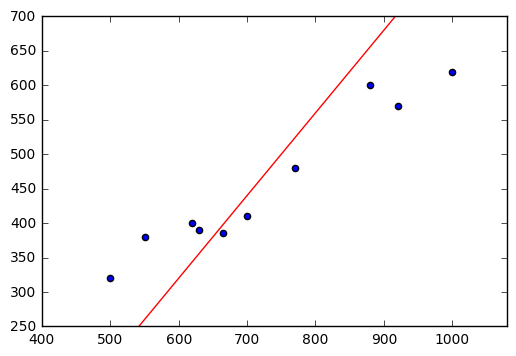

In [46]:
# data visualization
plt.scatter(df.Size, df.Price);
plt.plot(df.Size, df.Size*1.2-400, 'r');
plt.xlim([400, 1080]);
plt.ylim([250, 700]);

A standard approach is to select $m$ and $b$ that minimize the mean squared error (MSE) over the available dataset. For a given value of $m$ and $b$, and estimated output $\hat{y}$, the MSE is defined as:
$$MSE(m,b) = \frac{1}{2N} \sum_{i=1}^N \left(\hat{y}_i - y_i\right)^2 = \frac{1}{2N} \sum_{i=1}^N \left(m x_i + b - y_i\right)^2.$$

In [198]:
# the MSE for various values of slope m and y-intercept b:
m = np.linspace(-10, 15, 40);
b = np.linspace(-3000, 3000, 20);
MSEmb = np.zeros((len(m), len(b)));
for ii in range(len(m)):
    for jj in range(len(b)):
        MSEmb[ii,jj] = sum((m[ii]*df.Size + b[jj] - df.Price)**2)/(2*len(df))

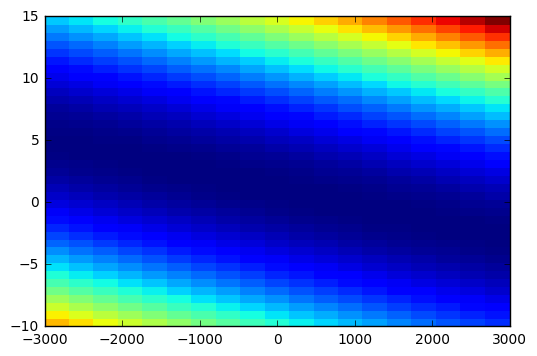

In [199]:
plt.pcolor(b, m, MSEmb);

## Minimizing Error

To minimize the MSE, consider the derivative with respect to each of the model parameters. The minimum MSE occurs where the derivative is zero with respect to both parameters:

$$\frac{\partial MSE}{\partial m} = \frac{1}{N} \sum_{i=1}^N ((m x_i + b) - y_i)x_i = 0  \Rightarrow m = \frac{\sum_{i=1}^N (b - y_i)x_i}{\sum_{i=1}^N x_i^2}$$

$$\frac{\partial MSE}{\partial b} = \frac{1}{N} \sum_{i=1}^N ((m x_i + b) - y_i) = 0 \Rightarrow b = \frac{\sum_{i=1}^N (m x_i - y_i)}{N}$$

This gives you a set of two coupled linear equations, which can be solved exactly... but it is often useful to use a more generally applicable iterative method like __gradient descent__.

## Gradient Descent

Gradient descent is a function-minimization (maximization) method that is used in a wide range of applications. 

* "Running down (up) hill" along direction of steepest descent (ascent).
* Can be slow to converge
* Can get stuck in local minima (maxima) (exception: convex problems, which only have one minimum (maximum))

How it works:
* Say we're optimizing $q = (b, m)$. At time step $i$, we have parameters $q_i = (b_i, m_i)$. We update the values using:
$$q_{i+1} = q_i - \alpha \frac{{\rm d}MSE}{{\rm d}q},$$
where $\alpha$ is the __learning rate__ and $\frac{{\rm d}MSE}{{\rm d}q} = \left(\frac{\partial MSE}{\partial b}, \frac{\partial MSE}{\partial m} \right)$.

Notes on choosing the learning rate:
* Choosing the learning rate is not an exact science. 
* A small learning rate can be slow to converge.
* A large learning rate can cause you to overshoot the minimum (maximum), and the algorithm could fail to converge.
* If the learning rate is too small or too large, it's often a good idea to choose a learning rate my multiplying by a constant factor (e.g. try 0.00001, 0.01, ..., 1, 10)
* To get the "best of both worlds" (a learning rate that is larger far from the minimum and smaller for finer adjustments as you reach the goal), the learning rate can decay over time with a fixed schedule (e.g. at time step $k$, $\alpha[k] = \alpha_0\frac{c}{c + k}$, where $\alpha_0$ is the base learning rate and $c$ is a constant specified by the user). 
* Another approach is to use an adaptive learning rate, like with Armijo step size (see https://en.wikipedia.org/wiki/Backtracking_line_search). Further reading: http://www.onmyphd.com/?p=gradient.descent.

In [213]:
# set step size:
a = 0.000001
N = len(df)

# set initial conditions
b = 10
m = 0.8

# set initial MSE values
MSE_old = 1.e8
MSE = sum(m*df.Size + b - df.Price)**2/(2*N)

steps = 0
MSE_vals = [MSE]
b_vals = [b]
m_vals = [m]

# run gradient descent:
while (MSE_old-MSE > 0.00001) and (steps < 1e5):
    # compute gradient
    dMSE_db = sum(m*df.Size + b - df.Price)/N
    dMSE_dm = sum((m*df.Size + b - df.Price)*df.Size)/N
    # update parameter values
    m -= a*dMSE_dm
    b -= a*dMSE_db
    # update MSE values
    MSE_old = MSE
    MSE = sum(m*df.Size + b - df.Price)**2/(2*N)
    MSE_vals.append(MSE)
    b_vals.append(b)
    m_vals.append(m)
    steps += 1

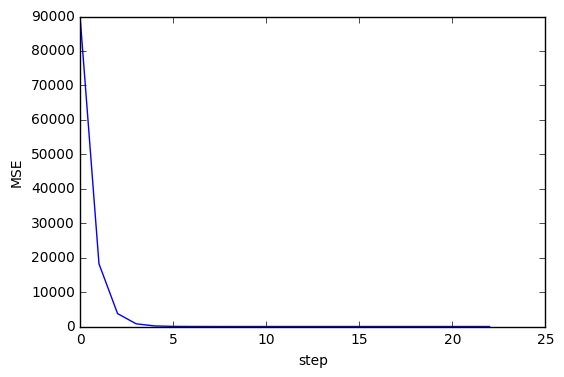

In [208]:
# descrease in MSE with incresing step number
plt.plot(MSE_vals);
plt.ylabel("MSE");
plt.xlabel("step");

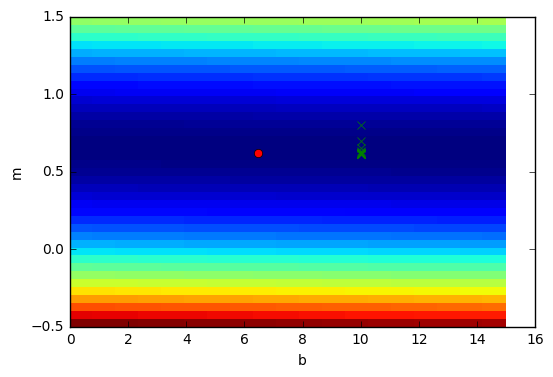

In [211]:
# path in parameter space
# the MSE for various values of slope m and y-intercept b:
mv = np.linspace(-0.5, 1.5, 40);
bv = np.linspace(0, 15, 20);
MSEmb = np.zeros((len(mv), len(bv)));
for ii in range(len(mv)):
    for jj in range(len(bv)):
        MSEmb[ii,jj] = sum((mv[ii]*df.Size + bv[jj] - df.Price)**2)/(2*len(df))
plt.pcolor(bv, mv, MSEmb);
plt.plot(b_vals, m_vals, 'xg');
plt.plot(6.47, 0.62, 'or');
plt.xlabel("b")
plt.ylabel("m")

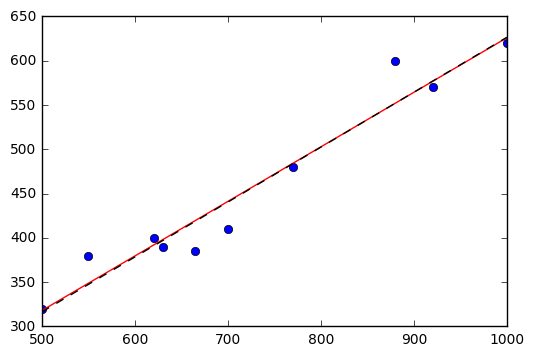

In [216]:
plt.plot(df.Size, df.Price, 'ob');
plt.plot(df.Size, m*df.Size+b, 'r');
plt.plot(df.Size, 0.62*df.Size+6.47, '--k');

# Multilinear Regression

Multilinear regression is the same as linear regression, but now you have more than one input feature. That is, you have a set of input features $x^1, \ldots, x^M$  and input-output data $(x^1_i, \ldots, x^M_i, y_i)$, and you are trying to optimize over parameters $(\beta_0, \beta_1, \ldots, \beta_M)$, where you assume a model of the form:
$$y = \beta_0 + \beta_1 x^1 + \ldots + \beta_M x^M$$
For convenience, it is helpful to define an additional "feature" $x^0$ that is always equal to $1$. Then you can write:
$$y = \beta_0 x^0 + \beta_1 x^1 + \ldots + \beta_M x^M = B^T X,$$
where $B = (\beta_0, \ldots, \beta_M)^T$ and $X = (x^0, \ldots, x^M)^T$.

Just like before, your goal is to minimize the MSE:
$$MSE(B) = \frac{1}{2N} \sum_{i=1}^N \left(\hat{y}_i - y_i\right)^2 = \frac{1}{2N} \sum_{i=1}^N \left(\beta_0 x^0_i + \ldots + \beta_M x^M_i - y_i\right)^2  = \frac{1}{2N} \sum_{i=1}^N \left(B^TX_i - y_i\right)^2.$$

Then you just use gradient descent like any other time. 

* It is often better to pre-process the data to get zero-mean features with similar variances (this can help e.g. avoid the problem in our linear regression example, where the gradient along $b$ is much smaller than the gradient along $m$). 

In [218]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [219]:
# linear regression model from sklearn
lin_mod = linear_model.LinearRegression()

In [222]:
lin_mod.fit(df[['Size','Floor','Rate']], df.Price)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [244]:
# Fit coefficients:
print('Coefficients: %s, %s'%(lin_mod.intercept_.astype(str), ", ".join(map(str, lin_mod.coef_))))

Coefficients: 19.5615588974, 0.548739846456, 4.96354676571, -0.0620951499088


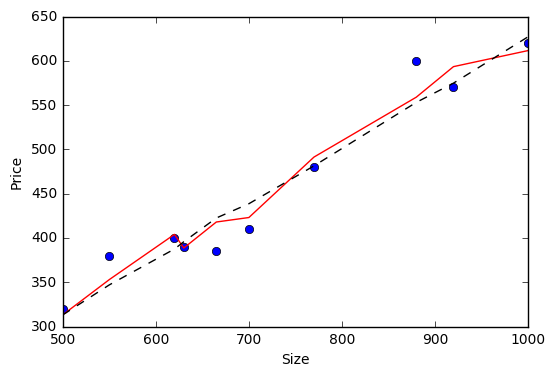

In [245]:
plt.plot(df.Size, df.Price, 'ob');
plt.plot(df.Size, lin_mod.intercept_ + lin_mod.coef_[0]*df.Size + lin_mod.coef_[1]*df.Floor + lin_mod.coef_[2]*df.Rate, 'r');
plt.plot(df.Size, -0.1513 + 0.6270*df.Size - 0.1781*df.Floor + 0.0714*df.Rate, '--k');
plt.xlabel("Size");
plt.ylabel("Price");

In [246]:
Price_pred = lin_mod.predict(df[['Size','Floor','Rate']])

In [248]:
mean_squared_error(df.Price, Price_pred)

448.45649596462601

In [249]:
r2_score(df.Price, Price_pred)

0.95520921911012746

# Other Things That Get Names For Some Reason

## Ridge Regression

Your (multi)linear regression becomes a ridge regression if you add an extra term to your cost function (rather than just using the MSE):
$$J(B) = \frac{1}{2N} \sum_{i=1}^N \left(\hat{y}_i - y_i\right)^2 + \frac{\lambda}{2M}\sum_{j=1}^M\beta_j^2.$$
* $\lambda$ is a parameter that must be set by the user
* This method can be useful to help prevent extreme values in the weights ($\beta_j$) for dominant features.

## LASSO Regression
Your (multi)linear regression becomes a LASSO regression if you add an extra term to your cost function (rather than just using the MSE):
$$J(B) = \frac{1}{2N} \sum_{i=1}^N \left(\hat{y}_i - y_i\right)^2 + \frac{\lambda}{2M}\sum_{j=1}^M\left|\beta_j\right|.$$
* $\lambda$ is a parameter that must be set by the user
* This method can be useful to help prevent extreme values in the weights ($\beta_j$) for dominant features.
* This method tends to bring weights for less significant features to $0$, and can be used as a method for automatic feature selection. 